<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Deploy a model in the cloud - P8</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Notebook - Proof of Concept |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries & static variables</h2>
</div>

In [21]:
## General
from io import BytesIO
from PIL import Image

## To use S3 files
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import sagemaker_pyspark

## To use S3 files
import botocore.session
import boto3

In [2]:
BUCKET = "oc-p8-bucket"
DUMMY_FILE = "SampleCSVFile_556kb.csv"

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1 loading the sagemaker jars </h3>
</div>

In [3]:
conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))
SparkContext(conf=conf)

<SparkContext master=local[*] appName=pyspark-shell>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Testing connection to S3</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to print the name of the first 5 elements in the S3.</p>
</div>

In [15]:
conn = boto3.client("s3")

In [17]:
contents = conn.list_objects(Bucket=BUCKET)["Contents"]
for k in list(contents)[:5]:
    print(k["Key"])

SampleCSVFile_556kb.csv
test/
test/images/
test/images/Apricot/0_100.jpg
test/images/Apricot/123_100.jpg


<div class="alert alert-block alert-info">
    <p>Now, we are going to test whether we can read an image from S3.</p>
</div>

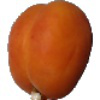

In [23]:
test_img = Image.open(
            BytesIO(
                conn.get_object(
                    Bucket=BUCKET, 
                    Key=list(contents)[5]["Key"])["Body"].read()
            )
        )

test_img

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Spark session</h2>
</div>

In [4]:
session = botocore.session.get_session()
credentials = session.get_credentials()

In [5]:
spark = (
    SparkSession
    .builder
    .config(conf=conf) \
    .config("fs.s3a.access.key", credentials.access_key)
    .config("fs.s3a.secret.key", credentials.secret_key)
    .appName("P8-FRUITS")
    .getOrCreate()
)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1 Testing connection to S3 with Spark</h3>
</div>

In [6]:
data_location = "s3a://{}/{}".format(BUCKET, DUMMY_FILE)

In [9]:
df_dummy = spark.read.csv(data_location, header="True", inferSchema=True)
df_dummy = df_dummy.drop("1")

In [10]:
df_dummy.limit(5).toPandas()

,"Eldon Base for stackable storage shelf, platinum",Muhammed MacIntyre,3,-213.25,38.94,35,Nunavut,Storage & Organization,0.8
0,"""1.7 Cubic Foot Compact """"Cube"""" Office Refrig...",Barry French,293,457.81,208.16,68.02,Nunavut,Appliances,0.58
1,"Cardinal Slant-D� Ring Binder, Heavy Gauge Vinyl",Barry French,293,46.71,8.69,2.99,Nunavut,Binders and Binder Accessories,0.39
2,R380,Clay Rozendal,483,1198.97,195.99,3.99,Nunavut,Telephones and Communication,0.58
3,Holmes HEPA Air Purifier,Carlos Soltero,515,30.94,21.78,5.94,Nunavut,Appliances,0.5
4,G.E. Longer-Life Indoor Recessed Floodlight Bulbs,Carlos Soltero,515,4.43,6.64,4.95,Nunavut,Office Furnishings,0.37


In [11]:
df_dummy.printSchema()

root
 |-- Eldon Base for stackable storage shelf, platinum: string (nullable = true)
 |-- Muhammed MacIntyre: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- -213.25: string (nullable = true)
 |-- 38.94: string (nullable = true)
 |-- 35: string (nullable = true)
 |-- Nunavut: string (nullable = true)
 |-- Storage & Organization: string (nullable = true)
 |-- 0.8: string (nullable = true)



<div class="alert alert-block alert-success">
    <p>Great !, we can access to S3 from ours Notebook through Spark / Pyspark</p>
</div>

In [36]:
image_df = spark.read.format("binaryfile").load("s3a://{}/{}".format(BUCKET, SUBFOLDER))

Py4JJavaError: An error occurred while calling o307.load.
: java.lang.ClassNotFoundException: Failed to find data source: binaryfile. Please find packages at http://spark.apache.org/third-party-projects.html
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:657)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:194)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:178)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.ClassNotFoundException: binaryfile.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20$$anonfun$apply$12.apply(DataSource.scala:634)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20$$anonfun$apply$12.apply(DataSource.scala:634)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20.apply(DataSource.scala:634)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20.apply(DataSource.scala:634)
	at scala.util.Try.orElse(Try.scala:84)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:634)
	... 13 more


In [ ]:
df_binary = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load("s3a://{}/{}".format(BUCKET, SUBFOLDER))

In [40]:
from pyspark.sql.functions import split

In [32]:
from pyspark.sql.functions import base64, col

In [34]:
image_df = spark.read.format("image").load("s3a://{}/{}".format(BUCKET, "test/images/Apricot/0_100.jpg"))

In [35]:
image_df

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

In [38]:
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [41]:
image_df = image_df.withColumn('label', split(col('path'), '/').getItem(4))
image_df = image_df.select('path', 'content', 'label')
image_df.show()

AnalysisException: "cannot resolve '`path`' given input columns: [image];;\n'Project [image#152, split('path, /)[4] AS label#154]\n+- Relation[image#152] image\n"